In [70]:
# Load our stuff
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
from scipy.stats import norm
import csv
import collections
from scipy.stats import norm
# Load options
import pandas as pd
import glob
from random import sample
from sim_data.sumstats import *
from sim_data.params import *
import math
import os
import torch
import torch.nn as nn

# Load df with all seqs
df = pd.read_pickle("./sim_data/data/full_edge_df.pk1")
parent_sequences = df['orig_seq']
run = sys.argv[0]
cm = ContextModel(3, 2, pkgutil.get_data("SHMModels", "data/aid_goodman.csv"))

train_batch_size = 25
train_data_size = 500
num_seqs = 2000


def hot_encode_dna_sequences(sequences):
    bases = ['A', 'C', 'G', 'T']
    num_bases = len(bases)
    
    # Create a dictionary to map bases to indices
    base_to_index = {base: index for index, base in enumerate(bases)}
    
    # Get the maximum length of the sequences
    max_length = max(len(seq) for seq in sequences)
    
    # Initialize an empty matrix to store the hot encoded sequences
    encoded_sequences = np.zeros((len(sequences), max_length, num_bases), dtype=int)
    
    # Iterate over each sequence and hot encode it
    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq):
            if base in base_to_index:
                encoded_sequences[i, j, base_to_index[base]] = 1
            else:
                # Handle unrecognized bases as desired (e.g., ignore or treat as zeros)
                pass
    
    return encoded_sequences

# Get batch (BER AND POL ETA DEFINED HERE)
def gen_batch_letters(seq,batch_size, params):
       # The prior specification
    ber_prob = params['ber_prob']
    ber_params = [0.25,0.25,0.25,0.25]
    
    bubble_size = 25.0
    pol_eta_params = {
        "A": [0.9, 0.02, 0.02, 0.06],
        "G": [0.01, 0.97, 0.01, 0.01],
        "C": [0.01, 0.01, 0.97, 0.01],
        "T": [0.06, 0.02, 0.02, 0.9],
    }
    prior_params = params
    exo_left = 1.0/prior_params['exo_left']
    exo_right = 1.0/prior_params['exo_right']
    mutated_seq_list = []
    for i in range(batch_size):
          mr = MutationRound(
          seq,
          ber_lambda=1.0,
          mmr_lambda=(1 - ber_prob)/ber_prob,
          replication_time=100,
          bubble_size=bubble_size,
          aid_time=10,
          exo_params={"left": exo_left, "right": exo_right},
          pol_eta_params=pol_eta_params,
          ber_params=ber_params,
          p_fw= prior_params['p_fw'],
          aid_context_model=cm,
          log_ls = prior_params['lengthscale'],
          sg = prior_params['gp_sigma'],
          fw_br = prior_params['fw_br'],
          rc_br = prior_params['rc_br'],
          off = prior_params['gp_offset']
          )
          mr.mutation_round()
          mutated_seq_list.append(SeqRecord(mr.repaired_sequence, id=""))
    return [list(i.seq) for i in mutated_seq_list]
# Generate batch of Param, Seq batch pairs
def gen_batch(batch_size, num_seqs, parent_sequences):
    X_par = []
    X_chi = []
    theta = []
    summ_stats = []
    for i in range(batch_size):
        true_model_params = sample_prior()
        true_params_array = np.array((true_model_params['lengthscale'],
                                     true_model_params['gp_sigma'],
                                     true_model_params['p_fw'],
                                     true_model_params['exo_left'] + true_model_params['exo_right'],
                                     true_model_params['ber_prob']))
        obs_sample = []
        parent_sample = sample(list(parent_sequences),num_seqs)
        for i in range(num_seqs):
            t_seq = gen_batch_letters(Seq(parent_sample[i]),1, true_model_params)
            obs_sample.append(t_seq[0])
        colocals = colocal_vector(parent_sample, obs_sample)
        exo = np.concatenate([get_exo_summ(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
        at = np.concatenate([get_pairwise_at(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
        c_counts, g_counts = get_cg_summ_sample(obs_sample,parent_sample)
        bp = base_prob(obs_sample,parent_sample)
        atp = at_frac(obs_sample,parent_sample)
        summ_stat = np.append(colocals,[np.mean(exo),np.mean(at), np.sum(c_counts)/(np.sum(c_counts) + np.sum(g_counts)), bp,atp])
        summ_stats.append(summ_stat)
        X_chi.append(hot_encode_dna_sequences(obs_sample))
        X_par.append(hot_encode_dna_sequences(parent_sample))
        theta.append(true_params_array)
    return X_chi,X_par,theta, summ_stats


train_X_chi,train_X_par, train_theta, summ_stats = gen_batch(train_data_size, num_seqs,parent_sequences)



In [71]:
training = [train_X_chi[i]-train_X_par[i] for i in range(len(train_X_chi))]
length = np.max([np.shape(i)[1] for i in train_X_chi])

for i in range(len(training)):
    if np.shape(training[i])[1] < length:
        dist = length - np.shape(training[i])[1]
        training[i] = np.concatenate((training[i],np.zeros((num_seqs,dist,4))), axis = 1)

summ_stats = np.nan_to_num(np.array(summ_stats))
summ_stats = (summ_stats - np.mean(summ_stats,axis = 0))/np.std(summ_stats, axis = 0)

class AttentionModel(nn.Module):
    def __init__(self, seq_length, conv_filters,
                 dropout):
        super().__init__()
        self.seq_length = seq_length
        self.conv_filters = conv_filters
        self.device = device

        self.dropout = nn.Dropout(p=dropout)

        self.conv = nn.Conv2d(1,self.conv_filters,(10,4), padding = 'same')
        self.enclayer = nn.TransformerEncoderLayer(d_model= 4*self.conv_filters, nhead = 1, dim_feedforward= 128,batch_first=True)
        self.linear = nn.Linear(self.seq_length*self.conv_filters*4, out_features= 256)
    def forward(self, x):

        x = x.to(self.device) 

        conv_out = self.conv(x)
        conv_out = torch.reshape(conv_out,(-1,self.seq_length,4*self.conv_filters))
        attn_out = self.enclayer(conv_out)
        attn_out = torch.reshape(attn_out, (-1,self.seq_length*self.conv_filters*4))
        out = self.linear(attn_out)
        return out



In [73]:
summ_stats[0,:]

array([ 1.29340292,  0.07158399, -1.27313791, -1.20718521, -1.39861404,
       -1.38575169, -1.16274279, -1.37771797, -1.30064178, -1.74307179,
       -1.32637309, -1.56556922, -1.48178289, -1.19285507, -1.25701779,
       -1.17981685, -1.37201264, -0.90164212, -0.74935794, -0.71179556,
       -1.38074079, -0.97642267, -1.17309837, -1.35547735, -0.84362268,
       -1.00060654, -1.20507871, -0.04490721, -0.32409889,  0.38231765,
       -0.0067185 , -1.17241399,  0.20884979, -0.86141773,  0.83777071,
       -0.25492512, -0.59541054, -0.68129023, -0.24127386, -0.56964266,
       -0.45301205, -0.25381815, -0.66190331,  0.41713723, -0.72735645,
       -1.46121985, -1.16755815,  0.94218526, -0.39324995,  0.51168044,
       -0.53661933,  0.11804617,  1.36391266,  0.17832259,  0.39683048,
        0.71692667,  0.55172003,  0.69157087, -0.9795927 , -0.0406661 ,
        0.2446962 ,  1.48323232,  2.87777393,  0.93920595, -1.00561922,
       -0.38177476, -0.45226625,  0.61204225, -0.12215603,  0.80

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionModel(length,10, 0.03)
model.load_state_dict(torch.load('sim_data/preds/model_hybrid_exo_split2'))
model.cuda()
linear = torch.load('sim_data/preds/linear_hybrid_exo_split2')

In [4]:
batch_preds = []
for i in range(100):
    print(i)
    idx = range((5*i),(5*i+5))
    batch_training = [training[i] for i in idx]
    training_tensors = [torch.reshape(torch.tensor(i).float(), (1000,1,length,4)).cuda() for i in batch_training]
    training_summ = torch.tensor(np.nan_to_num(np.array([summ_stats[i] for i in idx]))).float().cuda()
    embeds = [torch.mean(model(i),0) for i in training_tensors]
    embeds = torch.cat((torch.stack(embeds),training_summ),dim = 1)
    preds = linear(embeds)
    batch_preds.append(preds.cpu().detach().numpy())
    del training_tensors
    del embeds
    del preds

0


/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


1
2


IndexError: list index out of range

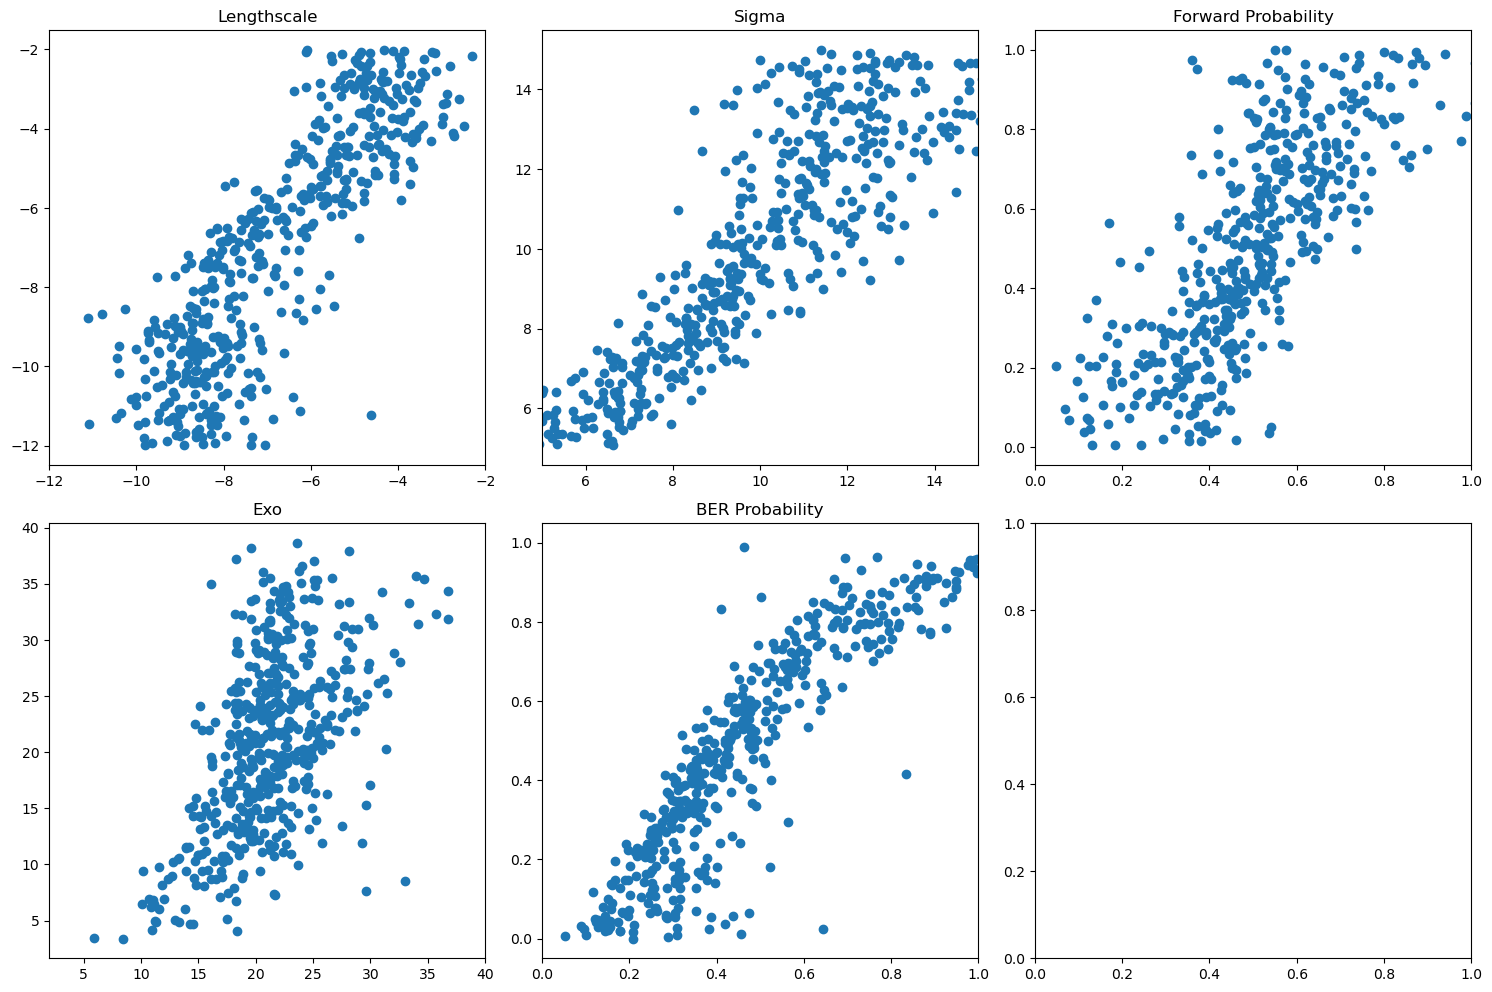

In [ ]:
import matplotlib.pyplot as plt
# Initialise the subplot function using number of rows and columns
preds = np.array(batch_preds).reshape((500,5))*np.std(train_theta,axis = 0) + np.mean(train_theta, axis =0)
labels = np.array(train_theta)
figure, axis = plt.subplots(2, 3)
  
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0,0].set_xlim([-12,-2])
axis[0, 0].set_title("Lengthscale")
  
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0,1].set_xlim([5,15])
axis[0, 1].set_title("Sigma")
  
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0,2].set_xlim([0,1])
axis[0, 2].set_title("Forward Probability")
  

axis[1, 0].scatter(preds[:,3], labels[:,3])
axis[1,0].set_xlim([2,40])
axis[1, 0].set_title("Exo")
  

axis[1, 1].scatter(preds[:,4], labels[:,4])
axis[1,1].set_xlim([0,1])
axis[1, 1].set_title("BER Probability")
  

figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
#plt.savefig('figures/scatter.png')
plt.show()


In [25]:
shuffle = []
for i in range(8):
    batch_preds = []
    for j in range(100):
        print(j)
        idx = range((5*j),(5*j+5))
        batch_training = [training[j] for j in idx].copy()
        training_tensors = [torch.reshape(torch.tensor(i).float(), (1000,1,length,4)).cuda() for i in batch_training]
        training_summ = np.nan_to_num(np.array([summ_stats[i] for i in idx]))
        embeds = torch.stack([torch.mean(model(i),0) for i in training_tensors]).cpu().detach().numpy()
        if i == 0:
            pass
        elif i == 1:
            for k in range(256):
                random.shuffle(embeds[:,k])
        elif i == 2:
            for k in range(100):
                random.shuffle(training_summ[:,k])
        else:
            random.shuffle(training_summ[:,97+i])
        embeds = torch.cat((torch.tensor(embeds),torch.tensor(training_summ)),dim = 1).float().cuda()
        preds = linear(embeds)
        batch_preds.append(preds.cpu().detach().numpy())
        del training_tensors
        del embeds
        del preds
    preds = np.array(batch_preds).reshape((500,5))*np.std(train_theta,axis = 0) + np.mean(train_theta, axis =0)
    shuffle.append(np.mean((preds-labels)**2,axis = 0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

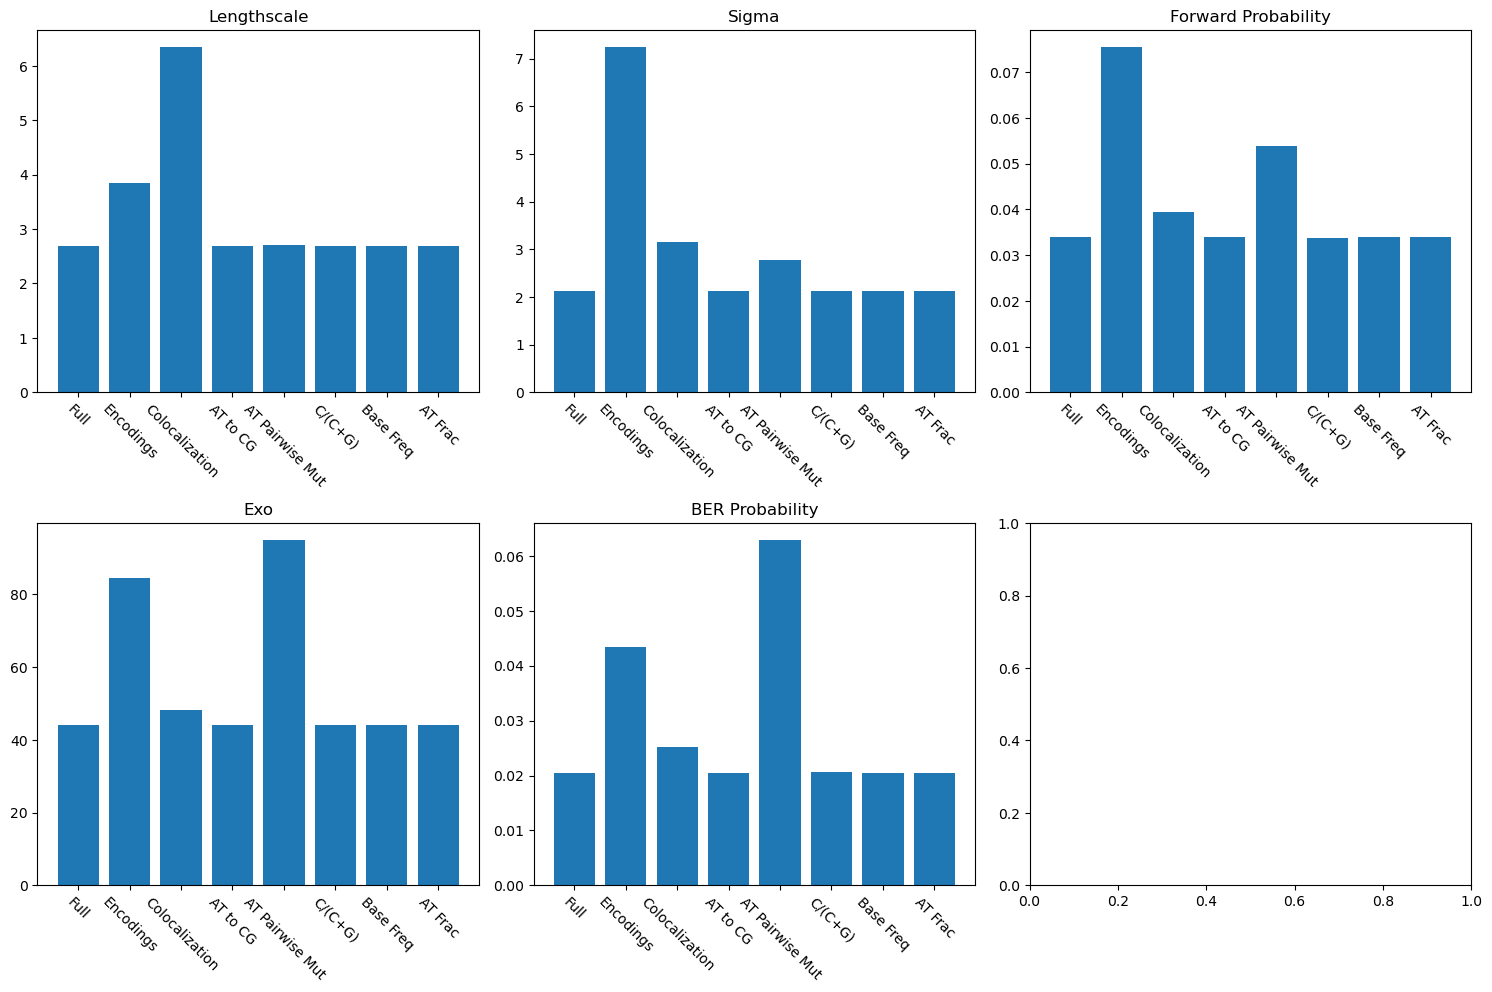

In [29]:
hist_labels = ['Full','Encodings', 'Colocalization', 'AT to CG', 'AT Pairwise Mut','C/(C+G)','Base Freq','AT Frac']
y_pos = range(len(hist_labels))
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].bar(y_pos,[shuffle[i][0] for i in range(8)])
axis[0, 0].set_title("Lengthscale")
axis[0,0].set_xticks(y_pos, hist_labels, rotation=-45)
# For Cosine Function
axis[0, 1].bar(y_pos,[shuffle[i][1] for i in range(8)])
axis[0, 1].set_title("Sigma")
axis[0,1].set_xticks(y_pos, hist_labels, rotation=-45)
# For Tangent Function
axis[0, 2].bar(y_pos,[shuffle[i][2] for i in range(8)])
axis[0, 2].set_title("Forward Probability")
axis[0,2].set_xticks(y_pos, hist_labels, rotation=-45)
# For Sine Function
axis[1, 0].bar(y_pos,[shuffle[i][3] for i in range(8)])
axis[1, 0].set_title("Exo")
axis[1,0].set_xticks(y_pos, hist_labels, rotation=-45)
# For Tangent Function
axis[1, 1].bar(y_pos,[shuffle[i][4] for i in range(8)])
axis[1, 1].set_title("BER Probability")
axis[1,1].set_xticks(y_pos, hist_labels, rotation=-45)
figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
#plt.savefig('figures/scatter.png')
plt.show()

In [20]:
np.shape(training[0])

(500, 424, 4)

In [5]:
import keras
summ_model = keras.models.load_model('sim_data/model')

2023-08-09 09:59:24.452542: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [15]:
summ_model.predict(summ_stats[0].reshape(1,105))

1/1 [==============================] - 0s 61ms/step


array([[ 17.841242,  30.188559,  -3.822392, -22.849115, -43.372883,
        -34.347385]], dtype=float32)

In [10]:
np.shape(summ_stats[0].reshape(1,105))

(1, 105)

In [47]:
# Load our stuff
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
from scipy.stats import norm
import csv
import collections
from scipy.stats import norm
# Load options
import pandas as pd
import glob
from random import sample
from sim_data.sumstats import *
from sim_data.params import *
import math
import os
import torch
import torch.nn as nn
import keras
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Load df with all seqs
df = pd.read_pickle("./sim_data/data/full_edge_df.pk1")
parent_sequences = df['orig_seq']
load = sys.argv[0]
cm = ContextModel(3, 2, pkgutil.get_data("SHMModels", "data/aid_goodman.csv"))

train_batch_size = 10
train_data_size = 10
num_seqs = 2000


def hot_encode_dna_sequences(sequences):
    bases = ['A', 'C', 'G', 'T']
    num_bases = len(bases)
    
    # Create a dictionary to map bases to indices
    base_to_index = {base: index for index, base in enumerate(bases)}
    
    # Get the maximum length of the sequences
    max_length = max(len(seq) for seq in sequences)
    
    # Initialize an empty matrix to store the hot encoded sequences
    encoded_sequences = np.zeros((len(sequences), max_length, num_bases), dtype=int)
    
    # Iterate over each sequence and hot encode it
    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq):
            if base in base_to_index:
                encoded_sequences[i, j, base_to_index[base]] = 1
            else:
                # Handle unrecognized bases as desired (e.g., ignore or treat as zeros)
                pass
    
    return encoded_sequences

# Get batch (BER AND POL ETA DEFINED HERE)
def gen_batch_letters(seq,batch_size, params):
       # The prior specification
    ber_prob = params['ber_prob']
    ber_params = [0.25,0.25,0.25,0.25]
    
    bubble_size = 25.0
    pol_eta_params = {
        "A": [0.9, 0.02, 0.02, 0.06],
        "G": [0.01, 0.97, 0.01, 0.01],
        "C": [0.01, 0.01, 0.97, 0.01],
        "T": [0.06, 0.02, 0.02, 0.9],
    }
    prior_params = params
    exo_left = 1.0/prior_params['exo_left']
    exo_right = 1.0/prior_params['exo_right']
    mutated_seq_list = []
    for i in range(batch_size):
          mr = MutationRound(
          seq,
          ber_lambda=1.0,
          mmr_lambda=(1 - ber_prob)/ber_prob,
          replication_time=100,
          bubble_size=bubble_size,
          aid_time=10,
          exo_params={"left": exo_left, "right": exo_right},
          pol_eta_params=pol_eta_params,
          ber_params=ber_params,
          p_fw= prior_params['p_fw'],
          aid_context_model=cm,
          log_ls = prior_params['lengthscale'],
          sg = prior_params['gp_sigma'],
          fw_br = prior_params['fw_br'],
          rc_br = prior_params['rc_br'],
          off = prior_params['gp_offset']
          )
          mr.mutation_round()
          mutated_seq_list.append(SeqRecord(mr.repaired_sequence, id=""))
    return [list(i.seq) for i in mutated_seq_list]
# Generate batch of Param, Seq batch pairs
def gen_batch(batch_size, num_seqs, parent_sequences):
    X_par = []
    X_chi = []
    theta = []
    summ_stats = []
    for i in range(batch_size):
        true_model_params = sample_prior()
        true_params_array = np.array((true_model_params['lengthscale'],
                                     true_model_params['gp_sigma'],
                                     true_model_params['p_fw'],
                                     true_model_params['exo_left'] + true_model_params['exo_right'],
                                     true_model_params['ber_prob']))
        obs_sample = []
        parent_sample = sample(list(parent_sequences),num_seqs)
        for i in range(num_seqs):
            t_seq = gen_batch_letters(Seq(parent_sample[i]),1, true_model_params)
            obs_sample.append(t_seq[0])
        colocals = colocal_vector(parent_sample, obs_sample)
        exo = np.concatenate([get_exo_summ(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
        at = np.concatenate([get_pairwise_at(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
        c_counts, g_counts = get_cg_summ_sample(obs_sample,parent_sample)
        bp = base_prob(obs_sample,parent_sample)
        atp = at_frac(obs_sample,parent_sample)
        summ_stat = np.append(colocals,[np.mean(exo),np.mean(at), np.sum(c_counts)/(np.sum(c_counts) + np.sum(g_counts)), bp,atp])
        summ_stats.append(summ_stat)
        X_chi.append(hot_encode_dna_sequences(obs_sample))
        X_par.append(hot_encode_dna_sequences(parent_sample))
        theta.append(true_params_array)
    return X_chi,X_par,theta, summ_stats


train_X_chi,train_X_par, train_theta, summ_stats = gen_batch(train_data_size, num_seqs,parent_sequences)
summ_stats = np.nan_to_num(np.array(summ_stats))
summ_stats = (summ_stats - np.mean(summ_stats,axis = 0))/np.std(summ_stats, axis = 0)
training = [train_X_chi[i]-train_X_par[i] for i in range(len(train_X_chi))]
length = np.max([np.shape(i)[1] for i in train_X_chi])

for i in range(len(training)):
    if np.shape(training[i])[1] < length:
        dist = length - np.shape(training[i])[1]
        training[i] = np.concatenate((training[i],np.zeros((num_seqs,dist,4))), axis = 1)



class AttentionModel(nn.Module):
    def __init__(self, seq_length, conv_filters,
                 dropout):
        super().__init__()
        self.seq_length = seq_length
        self.conv_filters = conv_filters
        self.device = device

        self.dropout = nn.Dropout(p=dropout)

        self.conv = nn.Conv2d(1,self.conv_filters,(10,4), padding = 'same')
        self.enclayer = nn.TransformerEncoderLayer(d_model= 4*self.conv_filters, nhead = 1, dim_feedforward= 128,batch_first=True)
        self.linear = nn.Linear(self.seq_length*self.conv_filters*4, out_features= 256)
    def forward(self, x):

        x = x.to(self.device) 

        conv_out = self.conv(x)
        conv_out = torch.reshape(conv_out,(-1,self.seq_length,4*self.conv_filters))
        attn_out = self.enclayer(conv_out)
        attn_out = torch.reshape(attn_out, (-1,self.seq_length*self.conv_filters*4))
        out = self.linear(attn_out)
        return out
if load:
    model = AttentionModel(length,10, 0.03)
    model.load_state_dict(torch.load('preds/model_hybrid_exo_split'))
    model.cuda()
    final_linear = torch.load('preds/linear_hybrid_exo_split')
else:
    model = AttentionModel(length,10, 0.03)
    final_linear = nn.Linear(361,5)
    model = model.to(device)
    final_linear = final_linear.to(device)
summ_model = keras.models.load_model('model')
param_means = np.array([-7.0,10.0,0.5,10.5,10.5,0.5])
param_sds = (1/np.sqrt(12))*np.array([10,10,1,18,18,1])

summ_preds = summ_model.predict(summ_stats)*param_sds+param_means

cuda


FileNotFoundError: [Errno 2] No such file or directory: 'preds/model_hybrid_exo_split'

In [74]:
summ_model = keras.models.load_model('sim_data/model')
param_means = np.array([-7.0,10.0,0.5,10.5,10.5,0.5])
param_sds = (1/np.sqrt(12))*np.array([10,10,1,18,18,1])

summ_preds = summ_model.predict(summ_stats)

16/16 [==============================] - 0s 4ms/step


In [75]:
model = AttentionModel(length,10, 0.03)
model.load_state_dict(torch.load('sim_data/preds/model_hybrid_exo_split2'))
model.cuda()
final_linear = torch.load('sim_data/preds/linear_hybrid_exo_split2')
batch_preds = []
for i in range(250):
    print(i)
    idx = range((2*i),(2*i+2))
    batch_training = [training[i] for i in idx]
    training_tensors = [torch.reshape(torch.tensor(i).float(), (2000,1,length,4)).cuda() for i in batch_training]
    training_summ = torch.tensor(summ_preds[idx,:]).float().cuda()
    embeds = [torch.mean(model(i),0) for i in training_tensors]
    embeds = torch.cat((torch.stack(embeds),training_summ),dim = 1)
    preds = linear(embeds)
    batch_preds.append(preds.cpu().detach().numpy())
    del training_tensors
    del embeds
    del preds

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


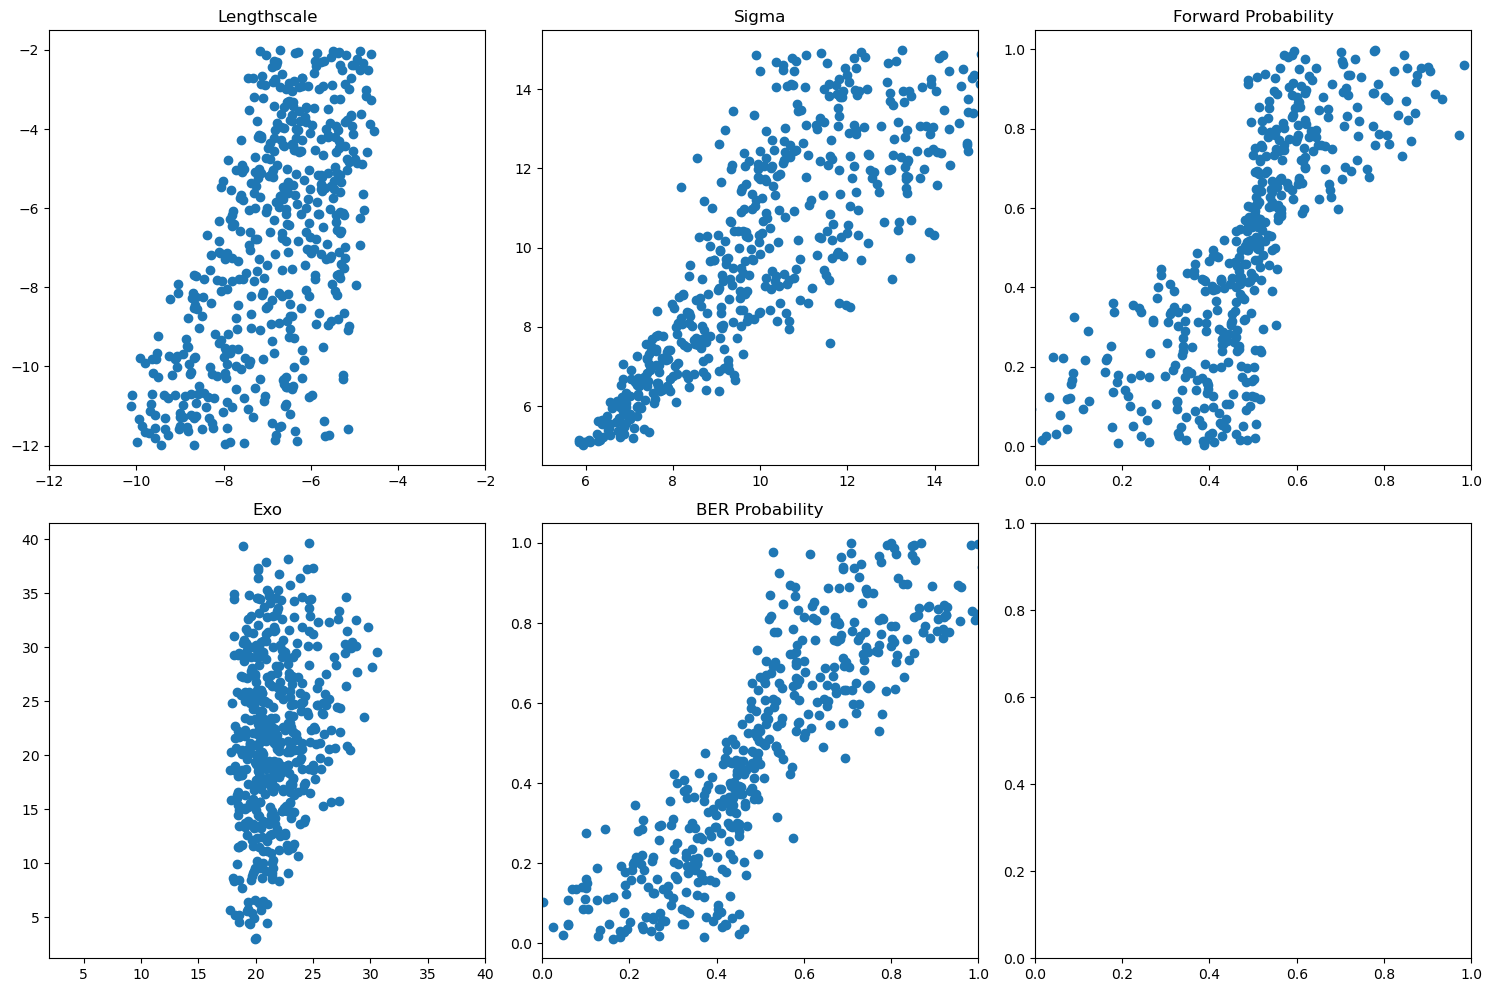

In [76]:
import matplotlib.pyplot as plt
# Initialise the subplot function using number of rows and columns
preds = np.array(batch_preds).reshape((500,5))*np.std(train_theta,axis = 0) + np.mean(train_theta, axis =0)
labels = np.array(train_theta)
figure, axis = plt.subplots(2, 3)
  
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0,0].set_xlim([-12,-2])
axis[0, 0].set_title("Lengthscale")
  
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0,1].set_xlim([5,15])
axis[0, 1].set_title("Sigma")
  
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0,2].set_xlim([0,1])
axis[0, 2].set_title("Forward Probability")
  

axis[1, 0].scatter(preds[:,3], labels[:,3])
axis[1,0].set_xlim([2,40])
axis[1, 0].set_title("Exo")
  

axis[1, 1].scatter(preds[:,4], labels[:,4])
axis[1,1].set_xlim([0,1])
axis[1, 1].set_title("BER Probability")
  

figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
#plt.savefig('figures/scatter.png')
plt.show()

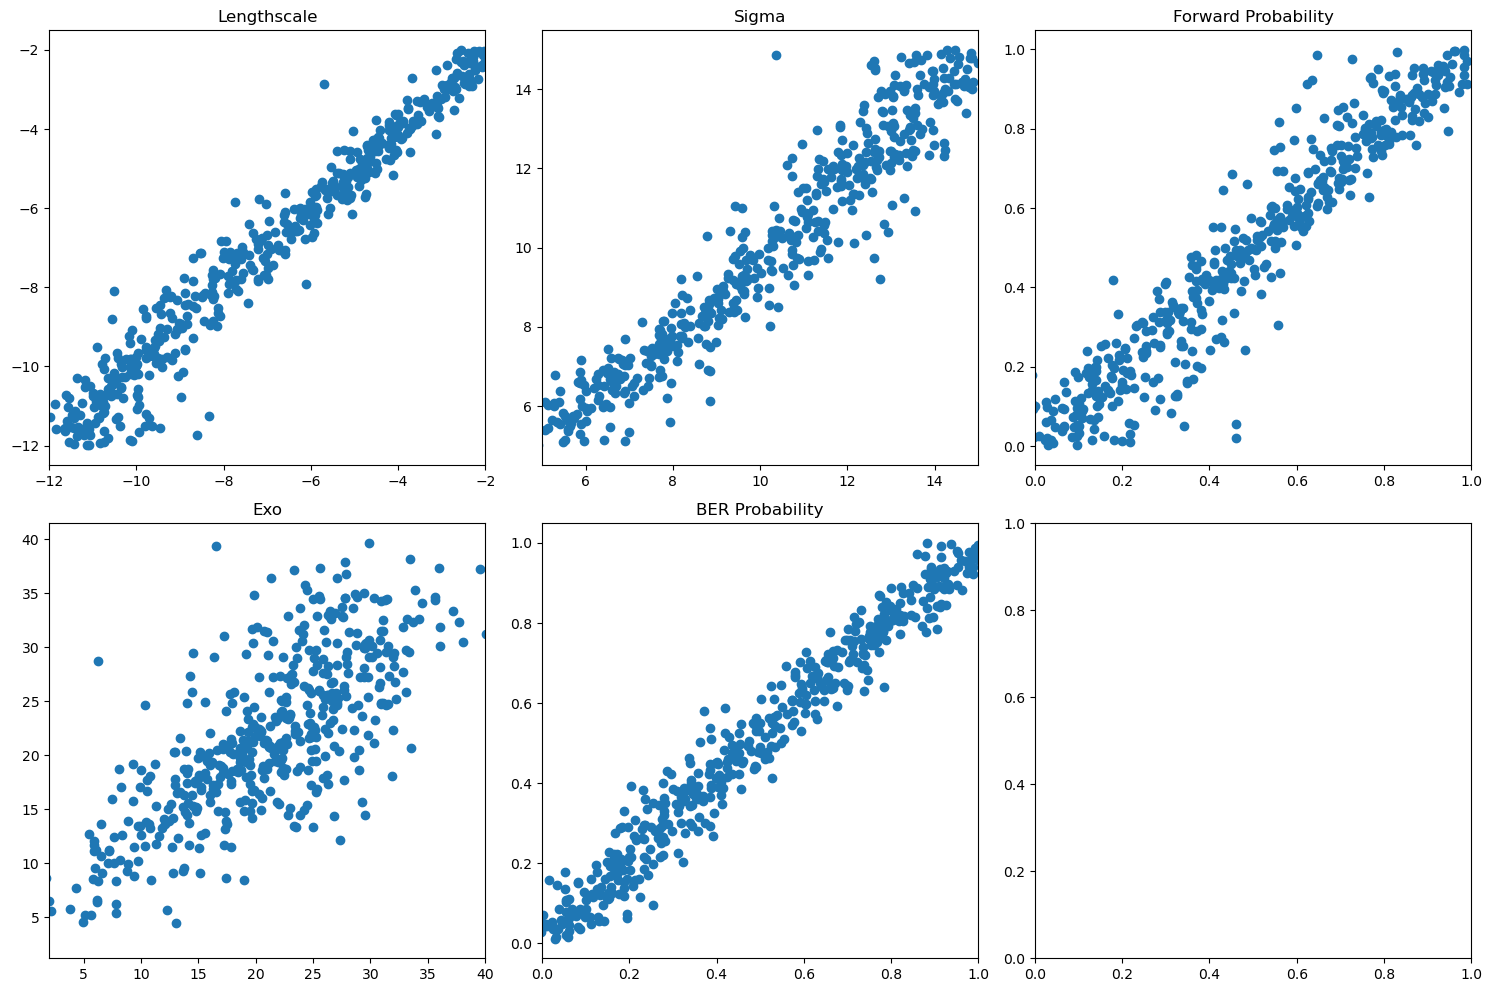

In [77]:
summ_preds_comb = np.concatenate((summ_preds[:,0:3],np.array(summ_preds[:,3]+summ_preds[:,4])[:,None],summ_preds[:,5][:,None]), axis = 1)

import matplotlib.pyplot as plt
# Initialise the subplot function using number of rows and columns
preds = np.array(summ_preds_comb).reshape((500,5))*np.std(train_theta,axis = 0) + np.mean(train_theta, axis =0)
labels = np.array(train_theta)
figure, axis = plt.subplots(2, 3)
  
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0,0].set_xlim([-12,-2])
axis[0, 0].set_title("Lengthscale")
  
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0,1].set_xlim([5,15])
axis[0, 1].set_title("Sigma")
  
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0,2].set_xlim([0,1])
axis[0, 2].set_title("Forward Probability")
  

axis[1, 0].scatter(preds[:,3], labels[:,3])
axis[1,0].set_xlim([2,40])
axis[1, 0].set_title("Exo")
  

axis[1, 1].scatter(preds[:,4], labels[:,4])
axis[1,1].set_xlim([0,1])
axis[1, 1].set_title("BER Probability")
  

figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
#plt.savefig('figures/scatter.png')
plt.show()

In [32]:
np.shape(summ_preds)

(500, 6)

In [67]:
summ_model.predict(summ_stats[:,:])

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 2ms/step


array([[-1.5123074 ,  1.282629  ,  0.52283096, -0.9602372 , -0.555138  ,
         1.2976019 ],
       [ 0.8844557 ,  0.7402478 , -0.63825476,  0.05083488,  0.6376997 ,
        -0.91596454],
       [ 1.2383887 , -0.17830288,  0.8165952 , -0.04171284, -0.58427334,
        -1.5038996 ],
       ...,
       [ 0.11456355, -0.40823278, -1.5325309 , -0.7362136 , -0.39098194,
        -0.32865968],
       [ 1.6002989 , -0.7075062 ,  0.81831306, -0.5249831 , -0.59375274,
        -1.2816749 ],
       [ 1.4739786 ,  1.6090614 , -0.844558  ,  0.44970328,  0.34934565,
         1.5381339 ]], dtype=float32)

In [51]:
summ_model.predict(n)

ValueError: in user code:

    File "/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/tfisher2/miniconda3/envs/shmpy/lib/python3.9/site-packages/keras/engine/input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [62]:
training

[array([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         

In [65]:
summ_stats[:,101] = 0

In [66]:
summ_stats[:,101]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.